In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load curve

In [8]:
data_load = pd.read_csv('data/load_profile_2018.csv',
    skiprows=3,
    usecols=[0, 1, 2],
    names=['datetime', 'load_real', 'load_pred'],
    dtype={1 : 'float'})
data_load.datetime = pd.to_datetime(data_load.datetime, dayfirst=True)

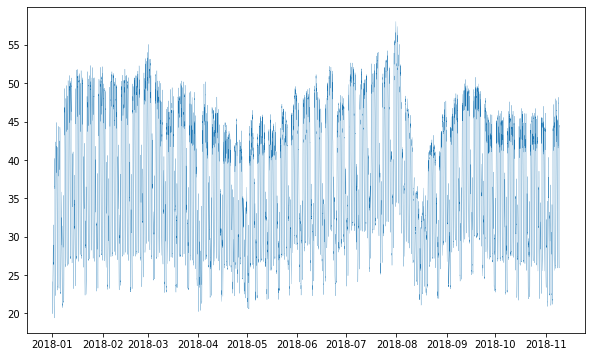

In [9]:
plt.figure(figsize=(10,6))
plt.plot(data_load.datetime, data_load.load_real, lw=0.2)

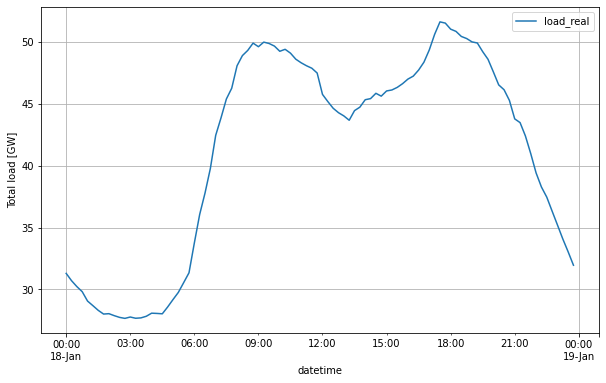

In [13]:
mask = (data_load.datetime >= '2018-01-18 00:00:00') & (data_load.datetime < '2018-01-19 00:00:00')
data_load_day = data_load[mask]
data_load_day.plot('datetime', 'load_real', figsize=(10,6))
plt.ylabel('Total load [GW]')
plt.grid()

Data are every 15 minutes. We want to have data every 30 minutes

In [14]:
def aggregate_data(load):
    loads = []
    for i in range(1, load.shape[0], 2):
        loads.append(np.mean(load[i:i+1]))
    times = np.arange(len(loads))
    return np.array(loads)

In [15]:
agg_real = aggregate_data(data_load.load_real) / 100 * 4.1
agg_pred = aggregate_data(data_load.load_pred) / 100 * 4.1

(0.0, 1000.0)

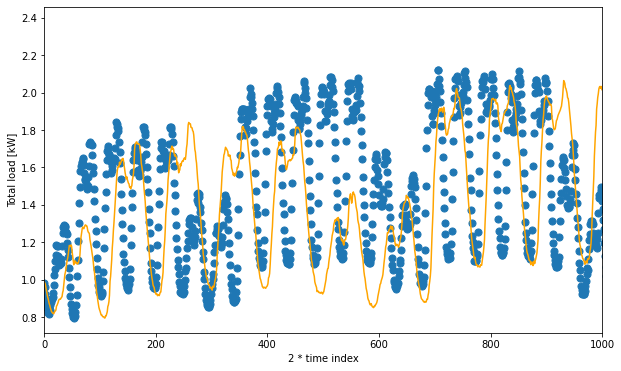

In [16]:
plt.figure(figsize=(10,6))
plt.plot(data_load.load_real / 100 * 4.1, c='orange')
plt.scatter(np.arange(len(agg_real)), agg_real, s=50)
plt.xlabel('2 * time index')
plt.ylabel('Total load [kW]');
plt.xlim(0, 1000)

In [16]:
np.save('data/load_agg_real.npy', agg_real)
np.save('data/load_agg_pred.npy', agg_pred)

 # Photovoltaic power production

In [17]:
sun_df = pd.read_csv('data/Sunny_day.csv', names=['time', 'power'], dtype='float')
cloud_df = pd.read_csv('data/Cloudy_day.csv', names=['time', 'power'], dtype='float')
rain_df = pd.read_csv('data/Rainy_day.csv', names=['time', 'power'], dtype='float')

sun_df.iloc[0] = [0, 0]
cloud_df.iloc[0] = [0, 0]
rain_df.iloc[0] = [0, 0]

In [18]:
from scipy.interpolate import interp1d
sunf = interp1d(sun_df.time, sun_df.power, kind='linear')
cloudf = interp1d(cloud_df.time, cloud_df.power, kind='linear')
rainf = interp1d(rain_df.time, rain_df.power, kind='linear')

factor = 2
x_points = np.arange(0, 24, 0.5)
sunny = sunf(x_points) / factor
cloudy = cloudf(x_points) / factor
rainy = rainf(x_points) / factor

In [19]:
cloudy_simp = sunny / 1.8
rainy_simp = sunny / 15

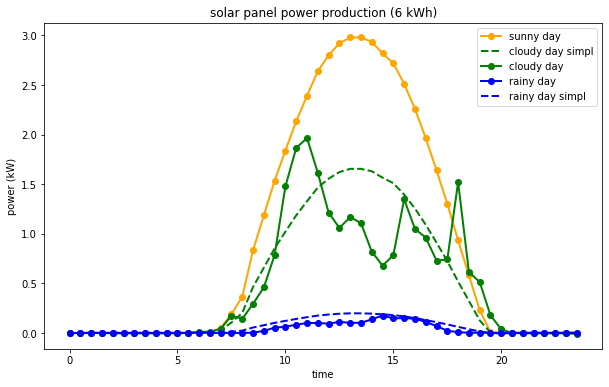

In [20]:
plt.figure(figsize=(10,6))
plt.xlabel('time')
plt.ylabel('power (kW)')
plt.title('solar panel power production (6 kWh)')
plt.plot(x_points, sunny, '-o', c='orange', lw=2, label='sunny day')
plt.plot(x_points, cloudy_simp, c='green', lw=2, ls='dashed', label='cloudy day simpl')
plt.plot(x_points, cloudy, '-o', c='green', lw=2, label='cloudy day')
plt.plot(x_points, rainy, '-o', c='blue', lw=2, label='rainy day')
plt.plot(x_points, rainy_simp, c='blue', lw=2, ls='dashed', label='rainy day simpl')
plt.legend()

In [6]:
panel_df = pd.DataFrame({'time' : x_points, 'sunny' : sunny, 'cloudy' : cloudy_simp, 'rainy' : rainy_simp})
panel_df.to_csv('data/panel_power.csv', sep=',')